In [3]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from evaluate import load
from nltk.translate.meteor_score import meteor_score
import nltk

# Download required nltk data
nltk.download('wordnet')

import re
import matplotlib.pyplot as plt

def remove_tokens(text):
    return re.sub(r'<[^>]*>', '', text)

def remove_tokens_from_column(df, column_name):
    df[column_name] = df[column_name].apply(remove_tokens)
    return df

def remove_lines(text):
    return text.split('\n')[0].strip()

def remove_lines_from_column(df, column_name):
    df[column_name] = df[column_name].apply(remove_lines)
    return df


/home/vfayosp/anaconda3/envs/bleu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to /home/vfayosp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
def calculate_bleu(reference, candidate):
    """
    Calculate the BLEU score for a candidate sentence against a reference sentence.
    
    Parameters:
        reference (str): The reference sentence.
        candidate (str): The candidate sentence.
    
    Returns:
        float: BLEU score.
    """
    
    if reference == candidate:
        return 1.0
    else:
        return sentence_bleu([reference], candidate)

def calculate_rouge(reference, candidate):
    """
    Calculate the ROUGE score for a candidate sentence against a reference sentence.
    
    Parameters:
        reference (str): The reference sentence.
        candidate (str): The candidate sentence.
    
    Returns:
        dict: ROUGE scores.
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, candidate)
    return scores

def calculate_bertscore(reference, candidate):
    """
    Calculate the BERTScore for a candidate sentence against a reference sentence.
    
    Parameters:
        reference (str): The reference sentence.
        candidate (str): The candidate sentence.
    
    Returns:
        tuple: Precision, recall, and F1 score.
    """
    P, R, F1 = bert_score([candidate.strip()], [reference.strip()], lang='en')
    return P.item(), R.item(), F1.item()

def calculate_meteor(reference, candidate):
    """
    Calculate the METEOR score for a candidate sentence against a reference sentence.
    
    Parameters:
        reference (str): The reference sentence.
        candidate (str): The candidate sentence.
    
    Returns:
        float: METEOR score.
    """
    return meteor_score([reference], candidate)


In [5]:
def add_all_scores(df, reference_column, candidate_column, bleu_column_name='BLEU', rouge_column_prefix='ROUGE', bertscore_column_prefix='BERTScore', meteor_column_name='METEOR'):
    """
    Add columns of BLEU, ROUGE, BERTScore, and METEOR scores to a DataFrame comparing candidate sentences to reference sentences.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        reference_column (str): Name of the column with reference sentences.
        candidate_column (str): Name of the column with candidate sentences.
        bleu_column_name (str): Name of the new column for BLEU scores. Default is 'BLEU'.
        rouge_column_prefix (str): Prefix for the new columns for ROUGE scores. Default is 'ROUGE'.
        bertscore_column_prefix (str): Prefix for the new columns for BERTScore scores. Default is 'BERTScore'.
        meteor_column_name (str): Name of the new column for METEOR scores. Default is 'METEOR'.
    
    Returns:
        pd.DataFrame: The DataFrame with the additional BLEU, ROUGE, BERTScore, and METEOR score columns.
    """
    def calculate_all_scores(row):
        reference = row[reference_column].strip()
        candidate = row[candidate_column].strip()
        
        bleu_score = calculate_bleu(reference.split(), candidate.split())
                        
        rouge_scores = calculate_rouge(reference, candidate)
        rouge_scores = {f"{rouge_column_prefix}_{key}": value.fmeasure for key, value in rouge_scores.items()}
                        
        meteor_score_value = calculate_meteor(reference.split(), candidate.split())
        
        P, R, F1 = calculate_bertscore(reference, candidate)
        bert_scores = {
            f"{bertscore_column_prefix}_Precision": P,
            f"{bertscore_column_prefix}_Recall": R,
            f"{bertscore_column_prefix}_F1": F1
        }
        
        return {bleu_column_name: bleu_score, **rouge_scores, **bert_scores, meteor_column_name: meteor_score_value}
    
    scores_df = df.apply(calculate_all_scores, axis=1, result_type='expand')
    df = pd.concat([df, scores_df], axis=1)
    return df


### Flan T5 XXL ###

In [41]:
wikipedia_flan_t5_df = pd.read_csv('flan-t5/wikipedia_with_flan_t5_shortest_answer.csv')
wikipedia_flan_t5_df = remove_tokens_from_column(wikipedia_flan_t5_df, 'flan-t5')
wikipedia_flan_t5_df_with_score = add_all_scores(wikipedia_flan_t5_df, 'answers', 'flan-t5')
wikipedia_flan_t5_df_with_score.to_csv('wikipedia_flan_t5_df_with_score.csv',index=False)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

<bound method DataFrame.info of                            id                       title  \
0    57304973947a6a140053d3af  Charleston,_South_Carolina   
1    56cf67c74df3c31400b0d72d             Frédéric_Chopin   
2    572697d6708984140094cb31                   Pesticide   
3    5726b53b708984140094ce7d     Raleigh,_North_Carolina   
4    5727a5273acd2414000de8c1                    Carnival   
..                        ...                         ...   
995  57269fea708984140094cc1d            Late_Middle_Ages   
996  572baafbf75d5e190021fe96              Czech_language   
997  5725c491ec44d21400f3d51c                      Israel   
998  56fa4d06f34c681400b0c076                        Wood   
999  5726e267dd62a815002e93de       Madonna_(entertainer)   

                                               context  \
0    Charleston is the primary medical center for t...   
1    Four boarders at his parents' apartments becam...   
2    Every dollar ($1) that is spent on pesticides ...   
3  

In [6]:
wikihow_flan_t5_df = pd.read_csv('flan-t5/wikihow_with_flan_t5.csv')
wikihow_flan_t5_df = remove_tokens_from_column(wikihow_flan_t5_df, 'flan-t5')
wikihow_flan_t5_df_with_score = add_all_scores(wikihow_flan_t5_df, 'headline', 'flan-t5')
wikihow_flan_t5_df_with_score.to_csv('wikihow_flan_t5_df_with_score.csv',index=False)

/home/vfayosp/anaconda3/envs/bleu/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the 

In [7]:
references = []
targets = []

for index, row in df.iterrows():
    references.append([row['answers'].strip().split()])
    targets.append(row['flan-t5'].strip().split())
print(corpus_bleu(references, targets))


0.48216089772682696


### Phi 3 Mini ###

In [46]:
wikipedia_phi_3_df = pd.read_csv('phi-3-mini/wikipedia_with_phi_3_shortest_answer.csv')
wikipedia_phi_3_df = remove_lines_from_column(wikipedia_phi_3_df, 'phi_3')
wikipedia_phi_3_df_with_score = add_all_scores(wikipedia_phi_3_df, 'answers', 'phi_3')
wikipedia_phi_3_df_with_score.to_csv('wikipedia_phi_3_df_with_score.csv',index=False)

/home/vfayosp/anaconda3/envs/bleu/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/vfayosp/anaconda3/envs/bleu/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/vfayosp/anaconda3/envs/bleu/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider usi

In [8]:
wikihow_phi_3_df = pd.read_csv('phi-3-mini/wikihow_with_phi_3.csv')
wikihow_phi_3_df_with_score = add_all_scores(wikihow_phi_3_df, 'headline', 'phi_3')
wikihow_phi_3_df_with_score.to_csv('wikihow_phi_3_df_with_score.csv',index=False)

/home/vfayosp/anaconda3/envs/bleu/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/vfayosp/anaconda3/envs/bleu/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(

In [5]:
references = []
targets = []

for index, row in df_phi.iterrows():
    references.append([row['answers'].strip().split()])
    targets.append(row['phi_3'].strip().split())
print(corpus_bleu(references, targets))

0.12057896376119392


### Yi 1.5 6B ###

In [47]:
wikipedia_yi_df = pd.read_csv('yi-1.5/wikipedia_with_yi_1_5_shortest_answer.csv')
wikipedia_yi_df_with_score = add_all_scores(wikipedia_yi_df, 'answers', 'yi-1.5')
wikipedia_yi_df_with_score.to_csv('wikipedia_yi_df_with_score.csv',index=False)

/home/vfayosp/anaconda3/envs/bleu/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/vfayosp/anaconda3/envs/bleu/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/vfayosp/anaconda3/envs/bleu/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider usi

In [51]:
wikihow_yi_df = pd.read_csv('yi-1.5/wikihow_with_yi_1_5.csv')
wikihow_yi_df_with_score = add_all_scores(wikihow_yi_df, 'headline', 'yi-1.5')
wikihow_yi_df_with_score.to_csv('wikihow_yi_df_with_score.csv',index=False)

/home/vfayosp/anaconda3/envs/bleu/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/vfayosp/anaconda3/envs/bleu/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infer

In [7]:
references = []
targets = []

for index, row in df_yi.iterrows():
    references.append([row['answers'].strip().split()])
    targets.append(row['yi-1.5'].strip().split())
print(corpus_bleu(references, targets))

0.08219860961420913


### Chat-GPT 3.5 ###

In [54]:
wikipedia_openai_df = pd.read_csv('openai/wikipedia_with_openai_shortest_answer.csv')
wikipedia_openai_df_with_score = add_all_scores(wikipedia_openai_df, 'answers', 'openai')
wikipedia_openai_df_with_score.to_csv('wikipedia_openai_df_with_score.csv',index=False)

/home/vfayosp/anaconda3/envs/bleu/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/vfayosp/anaconda3/envs/bleu/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infer

KeyboardInterrupt: 

In [55]:
wikihow_openai_df = pd.read_csv('openai/wikihow_with_openai.csv')
wikihow_openai_df_with_score = add_all_scores(wikihow_openai_df, 'headline', 'openai')
wikihow_openai_df_with_score.to_csv('wikihow_openai_df_with_score.csv',index=False)

/home/vfayosp/anaconda3/envs/bleu/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/vfayosp/anaconda3/envs/bleu/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infer

### Plots ###

#### Wikipedia ####

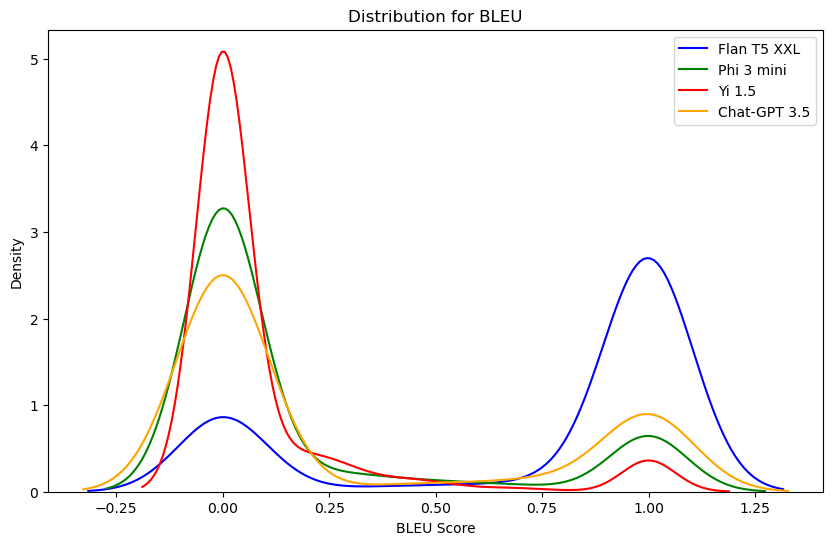

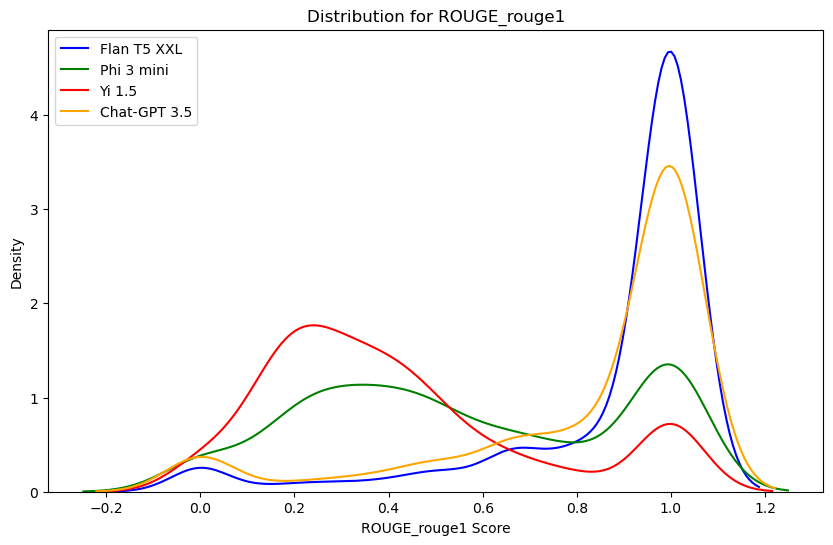

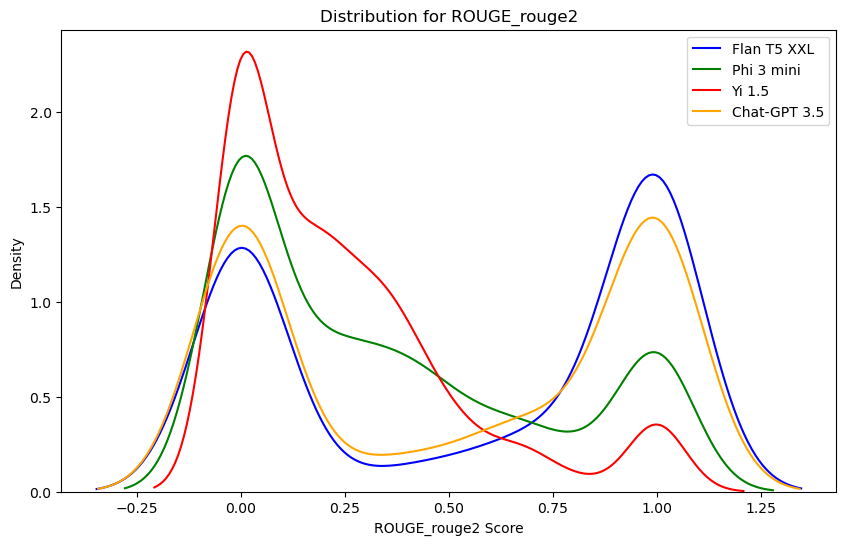

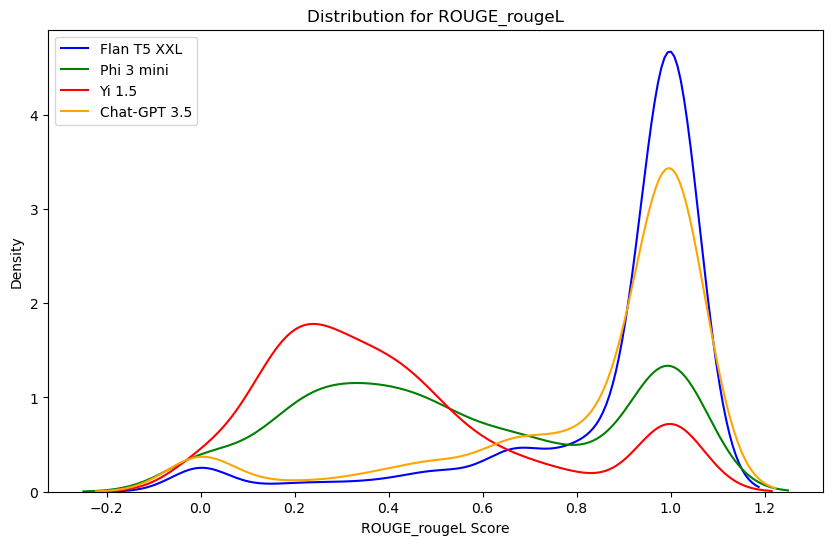

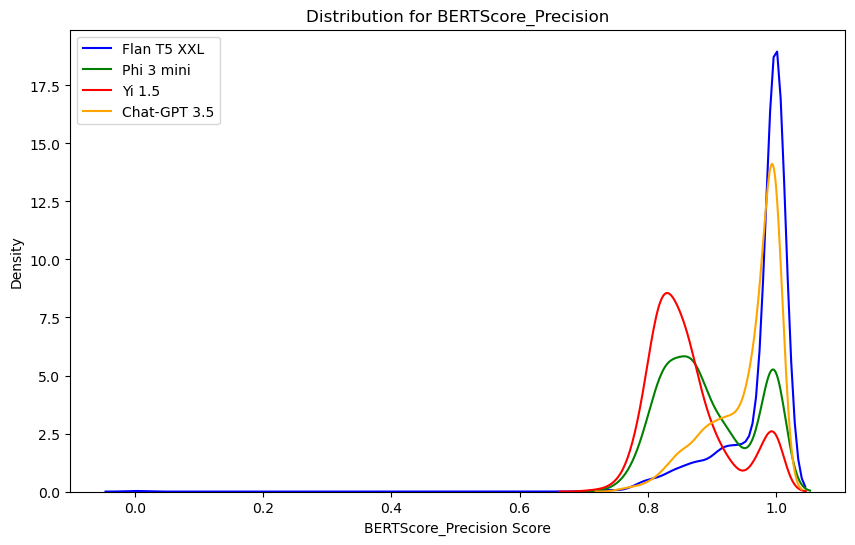

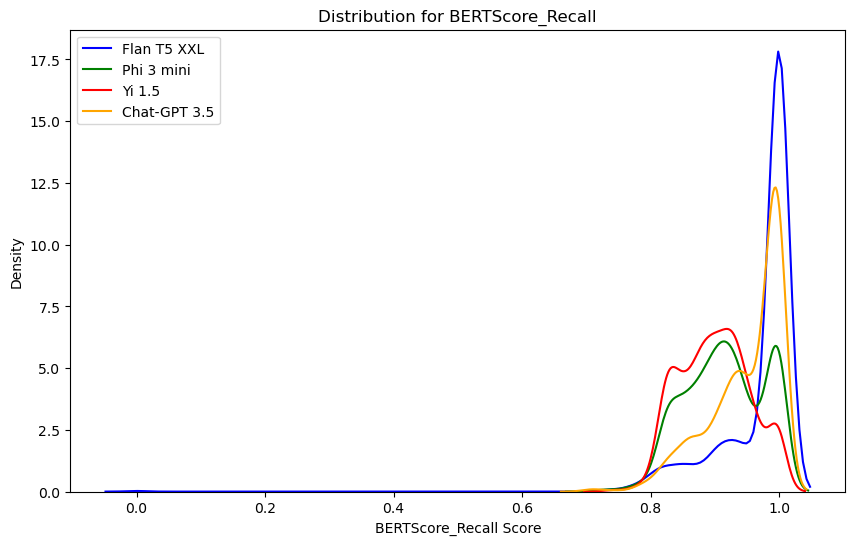

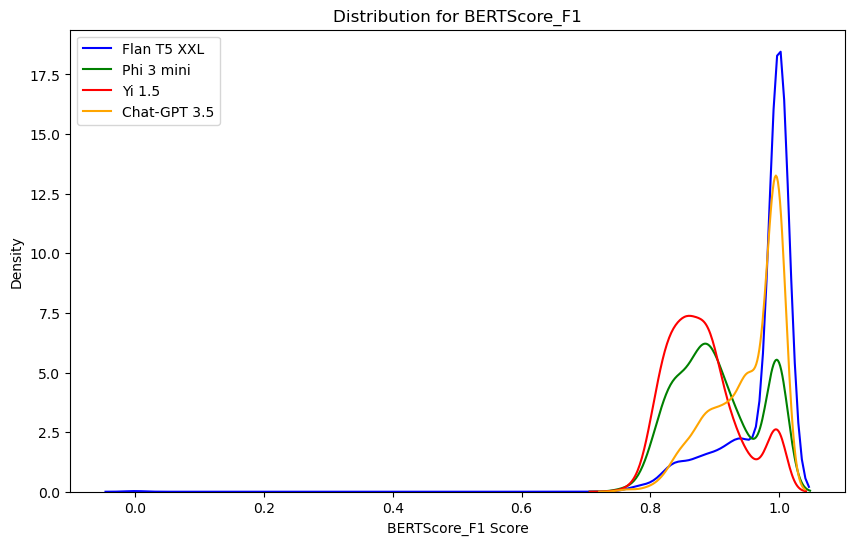

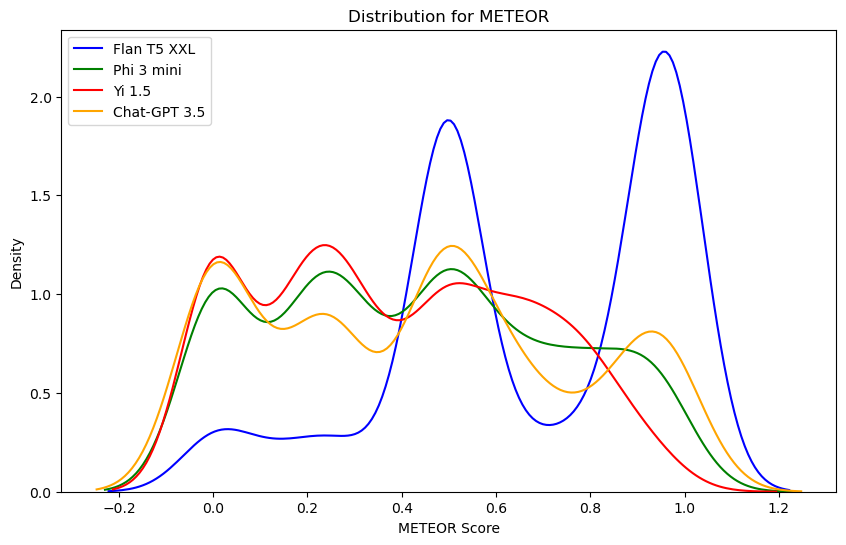

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

flan_t5 = pd.read_csv('results/wikipedia/wikipedia_flan_t5_df_with_score.csv')
phi_3 = pd.read_csv('results/wikipedia/wikipedia_phi_3_df_with_score.csv')
yi_1_5 = pd.read_csv('results/wikipedia/wikipedia_yi_df_with_score.csv')
openai = pd.read_csv('results/wikipedia/wikipedia_openai_df_with_score.csv')

dfs = [flan_t5, phi_3, yi_1_5, openai]
dfs_names = {0:'Flan T5 XXL', 1:'Phi 3 mini', 2:'Yi 1.5', 3:'Chat-GPT 3.5'}
colors = ['blue', 'green', 'red', 'orange']

column_plots = ['BLEU', 
                'ROUGE_rouge1',
                'ROUGE_rouge2',
                'ROUGE_rougeL',
                'BERTScore_Precision',
                'BERTScore_Recall',
                'BERTScore_F1',
                'METEOR'
                ]

for col in column_plots:
    plt.figure(figsize=(10, 6))
    for i, df in enumerate(dfs):
        sns.kdeplot(df[col], color=colors[i], label=dfs_names[i])
    plt.title(f'Distribution for {col}')
    plt.xlabel(f'{col} Score')
    plt.ylabel('Density')
    plt.legend()
    plt.savefig(f'results/wikipedia/{col}_wikipedia.png', dpi=600)
    plt.show()
    




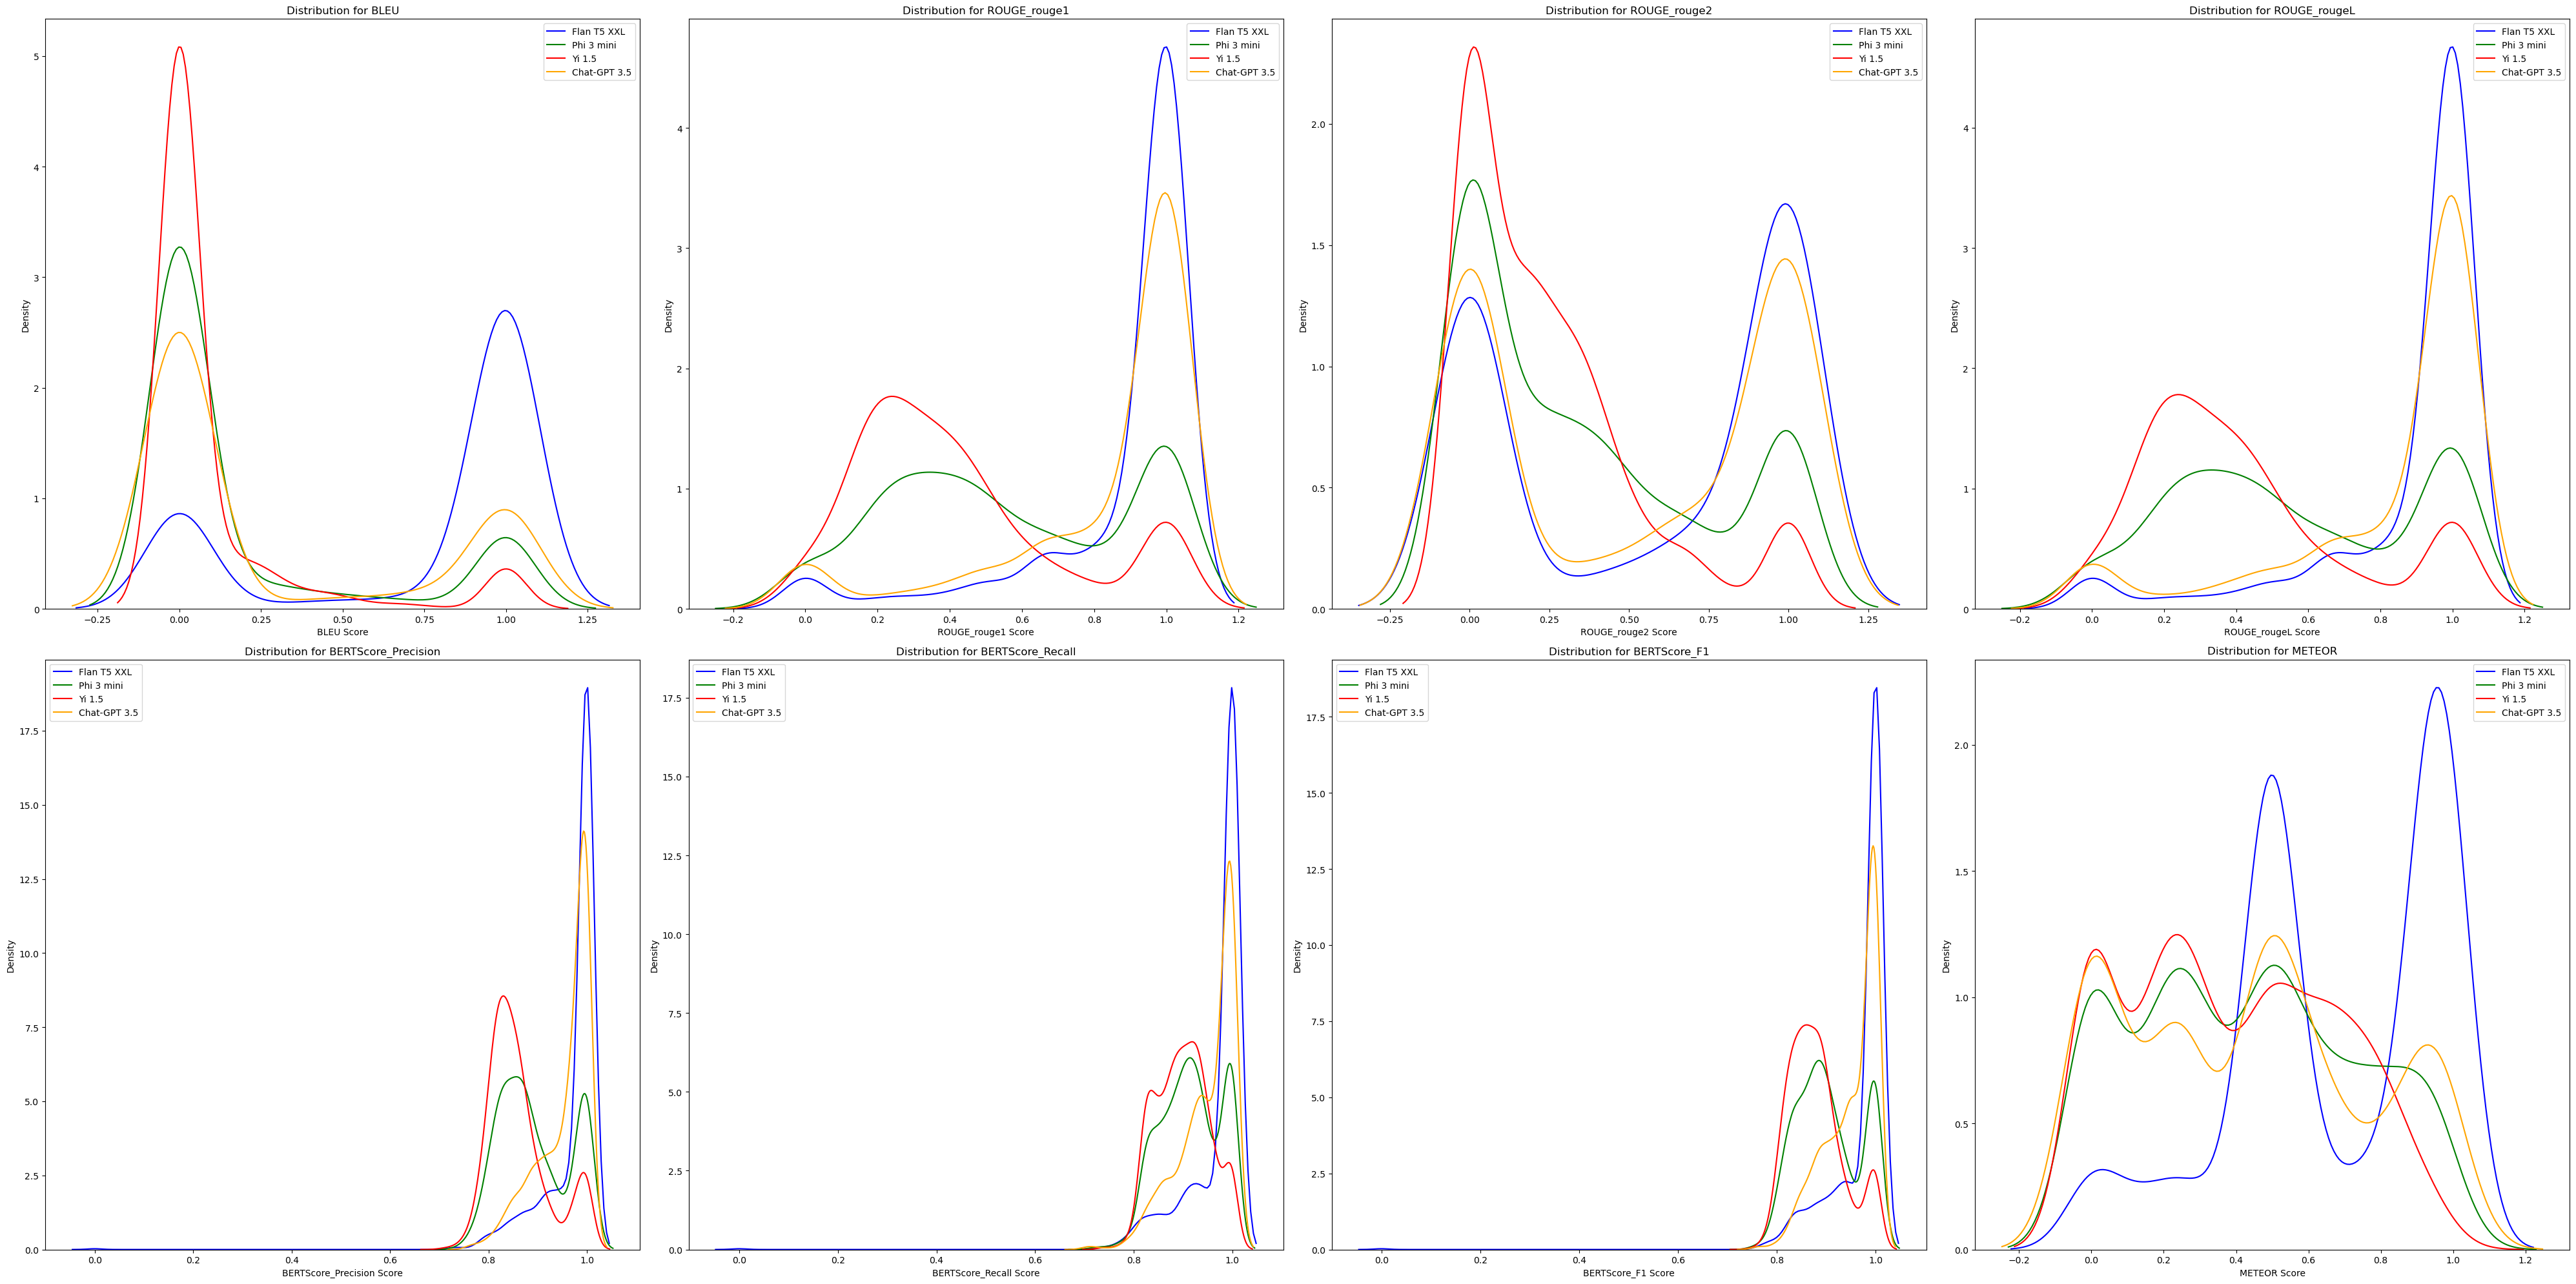

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
flan_t5 = pd.read_csv('results/wikipedia/wikipedia_flan_t5_df_with_score.csv')
phi_3 = pd.read_csv('results/wikipedia/wikipedia_phi_3_df_with_score.csv')
yi_1_5 = pd.read_csv('results/wikipedia/wikipedia_yi_df_with_score.csv')
openai = pd.read_csv('results/wikipedia/wikipedia_openai_df_with_score.csv')

# Define data and parameters
dfs = [flan_t5, phi_3, yi_1_5, openai]
dfs_names = {0: 'Flan T5 XXL', 1: 'Phi 3 mini', 2: 'Yi 1.5', 3: 'Chat-GPT 3.5'}
colors = ['blue', 'green', 'red', 'orange']
column_plots = ['BLEU', 
                'ROUGE_rouge1',
                'ROUGE_rouge2',
                'ROUGE_rougeL',
                'BERTScore_Precision',
                'BERTScore_Recall',
                'BERTScore_F1',
                'METEOR']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 25))
axes = axes.flatten()
# Plot each column in a subplot
for idx, col in enumerate(column_plots):
    ax = axes[idx]
    for i, df in enumerate(dfs):
        sns.kdeplot(df[col], color=colors[i], label=dfs_names[i], ax=ax)
    ax.set_title(f'Distribution for {col}')
    ax.set_xlabel(f'{col} Score')
    ax.set_ylabel('Density')
    ax.legend()

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('results/wikipedia/all_distributions_wikipedia.png', dpi=600)
plt.show()


#### WikiHow ####

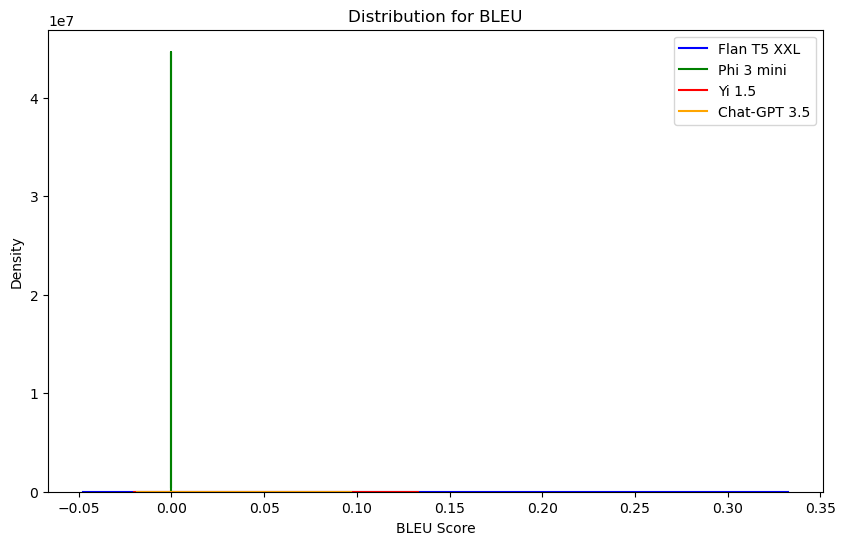

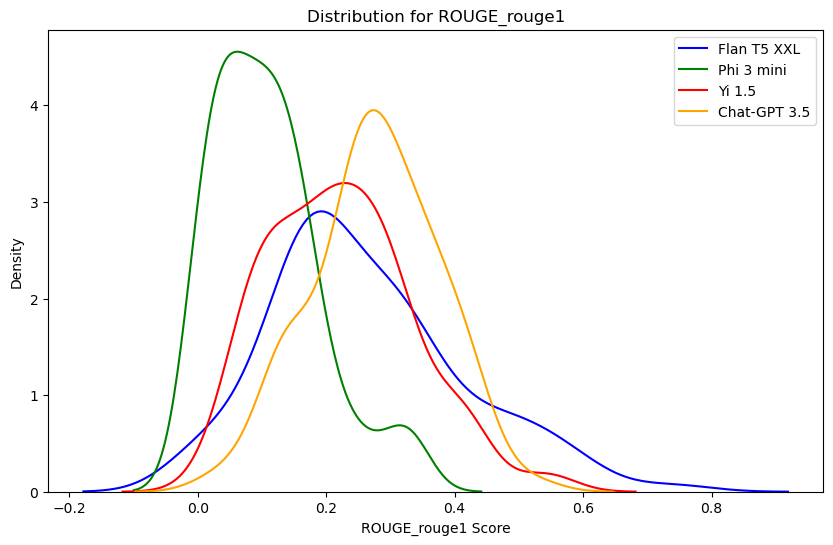

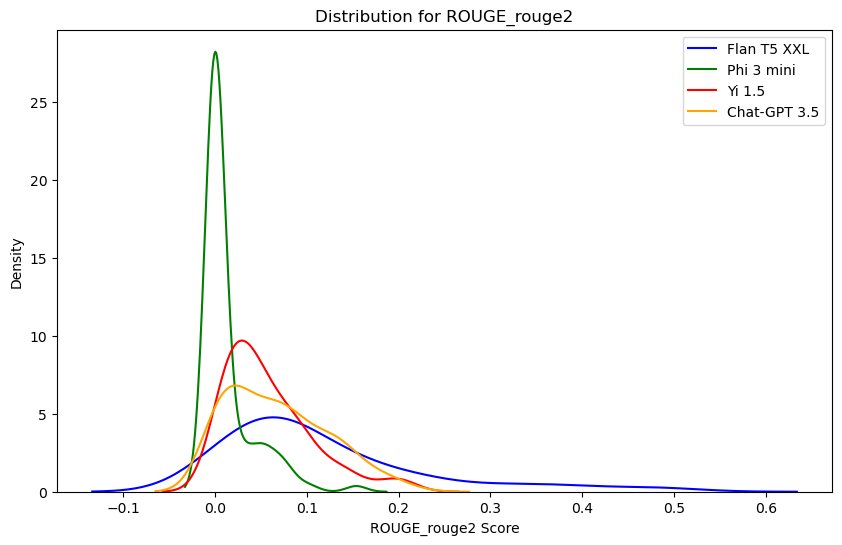

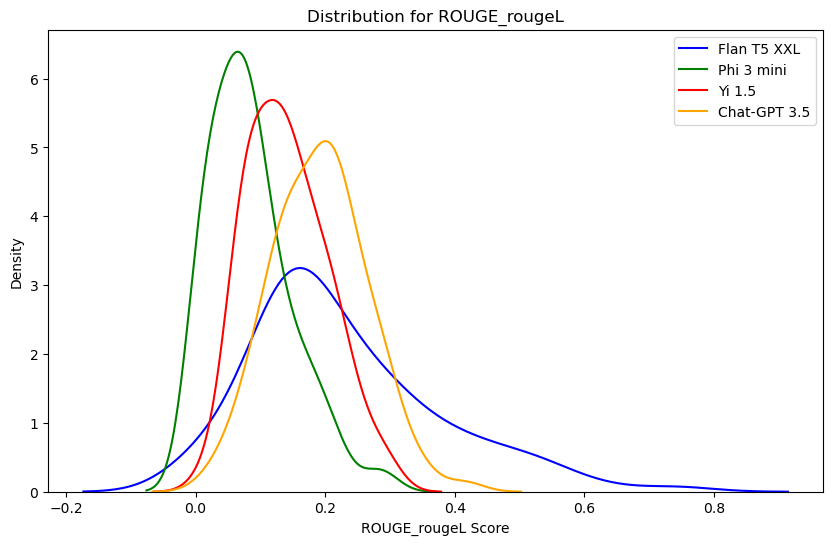

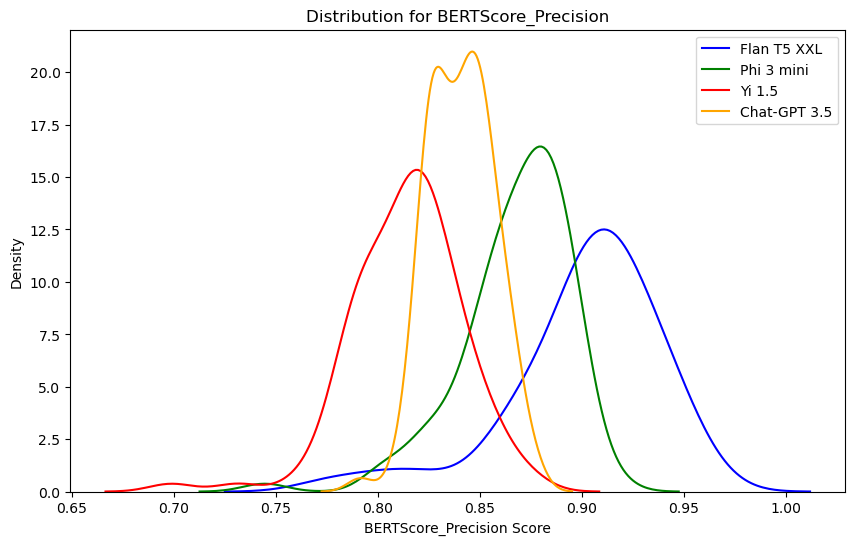

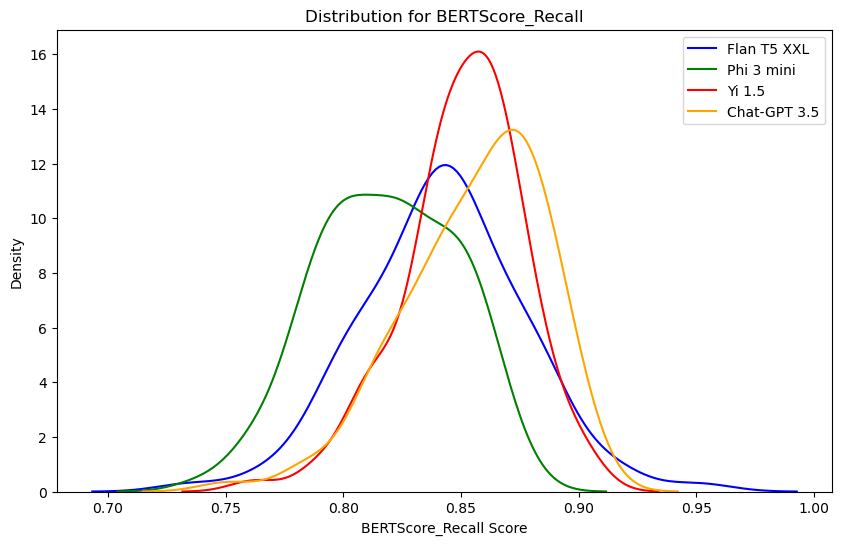

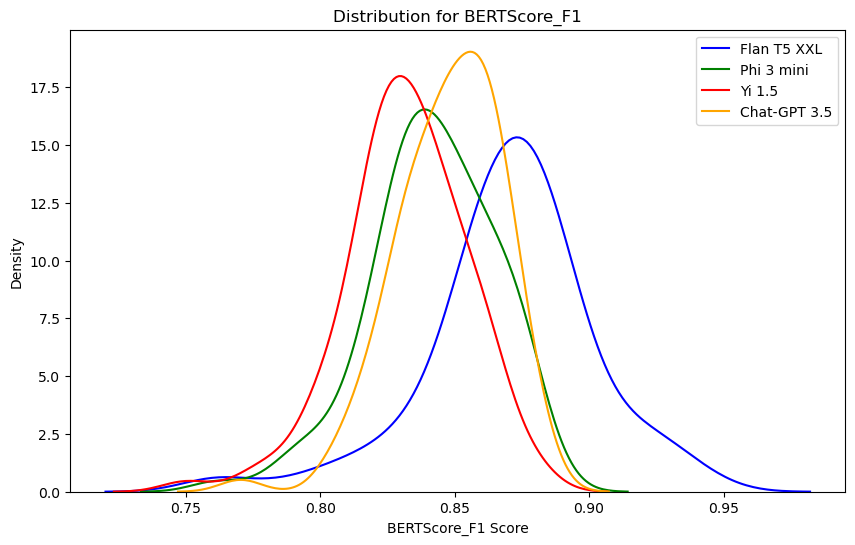

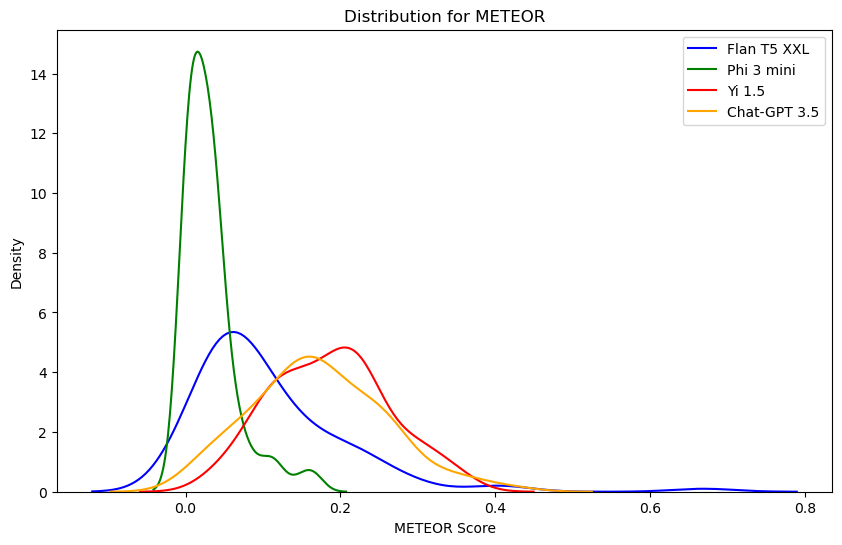

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

flan_t5 = pd.read_csv('results/wikihow/wikihow_flan_t5_df_with_score.csv')
phi_3 = pd.read_csv('results/wikihow/wikihow_phi_3_df_with_score.csv')
yi_1_5 = pd.read_csv('results/wikihow/wikihow_yi_df_with_score.csv')
openai = pd.read_csv('results/wikihow/wikihow_openai_df_with_score.csv')

dfs = [flan_t5, phi_3, yi_1_5, openai]
dfs_names = {0:'Flan T5 XXL', 1:'Phi 3 mini', 2:'Yi 1.5', 3:'Chat-GPT 3.5'}
colors = ['blue', 'green', 'red', 'orange']

column_plots = ['BLEU', 
                'ROUGE_rouge1',
                'ROUGE_rouge2',
                'ROUGE_rougeL',
                'BERTScore_Precision',
                'BERTScore_Recall',
                'BERTScore_F1',
                'METEOR'
                ]

for col in column_plots:
    plt.figure(figsize=(10, 6))
    for i, df in enumerate(dfs):
        sns.kdeplot(df[col], color=colors[i], label=dfs_names[i])
    plt.title(f'Distribution for {col}')
    plt.xlabel(f'{col} Score')
    plt.ylabel('Density')
    plt.legend()
    plt.savefig(f'results/wikihow/{col}_wikihow.png', dpi=600)
    plt.show()
    



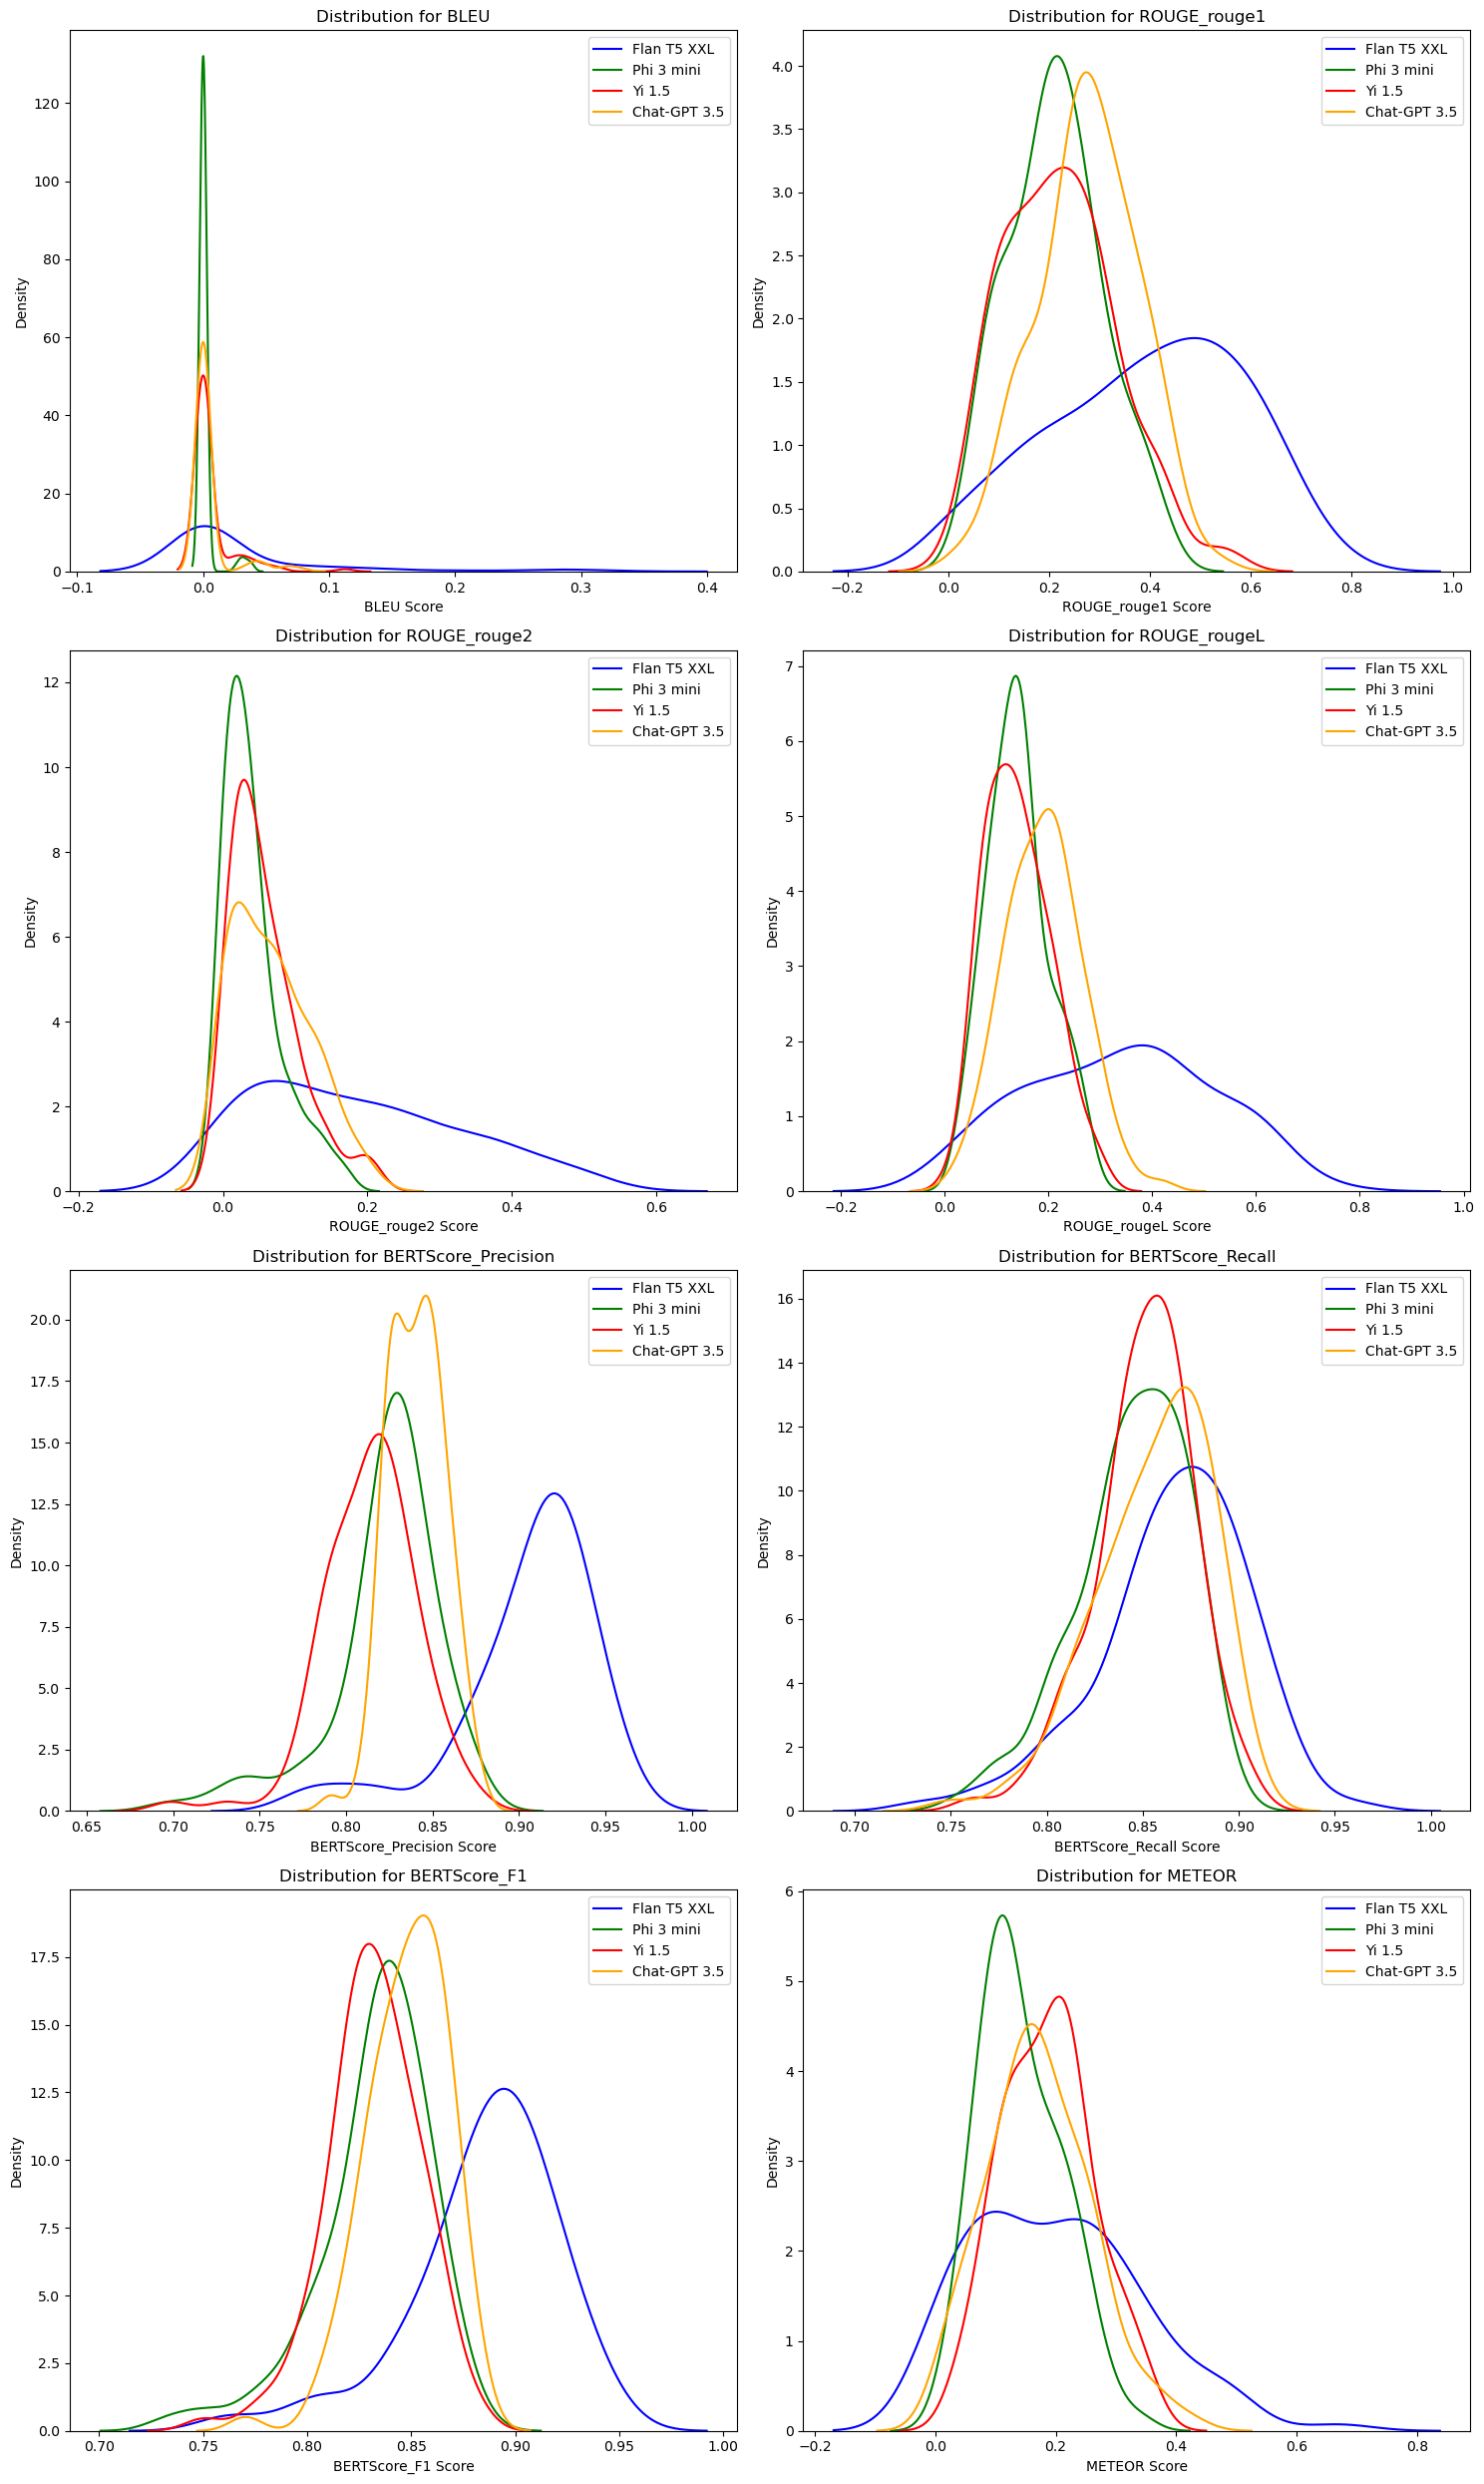

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
flan_t5 = pd.read_csv('results/wikihow/wikihow_flan_t5_df_with_score.csv')
phi_3 = pd.read_csv('results/wikihow/wikihow_phi_3_df_with_score.csv')
yi_1_5 = pd.read_csv('results/wikihow/wikihow_yi_df_with_score.csv')
openai = pd.read_csv('results/wikihow/wikihow_openai_df_with_score.csv')

# Define data and parameters
dfs = [flan_t5, phi_3, yi_1_5, openai]
dfs_names = {0: 'Flan T5 XXL', 1: 'Phi 3 mini', 2: 'Yi 1.5', 3: 'Chat-GPT 3.5'}
colors = ['blue', 'green', 'red', 'orange']
column_plots = ['BLEU', 
                'ROUGE_rouge1',
                'ROUGE_rouge2',
                'ROUGE_rougeL',
                'BERTScore_Precision',
                'BERTScore_Recall',
                'BERTScore_F1',
                'METEOR']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 25))
axes = axes.flatten()  # Flatten the 2D array of axes

# Plot each column in a subplot
for idx, col in enumerate(column_plots):
    ax = axes[idx]
    for i, df in enumerate(dfs):
        sns.kdeplot(df[col], color=colors[i], label=dfs_names[i], ax=ax)
    ax.set_title(f'Distribution for {col}')
    ax.set_xlabel(f'{col} Score')
    ax.set_ylabel('Density')
    ax.legend()

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('results/wikihow/all_distributions_wikihow.png', dpi=400)
plt.show()
